Loading datasets...
Transit Data Sample:
        date          station day_of_week  hour weather  temperature  entries  exits  nearby_events  service_disruptions  rideshare_activity  bike_share_docks  bus_connections  total_activity  \
0 2023-01-01  Columbus Circle      Monday    17   Sunny           47     1807   2755              2                    1                 607                21                0            4562   
1 2023-01-02     Penn Station      Sunday     8   Sunny           94     1716   3565              1                    1                 391                16                3            5281   
2 2023-01-03    Fulton Street    Thursday    18   Snowy           84     2835   1392              2                    1                 401                35                0            4227   
3 2023-01-04  Brooklyn Bridge   Wednesday    23   Rainy           68      769   2276              2                    1                 986                16                5    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pari3\AppData\Roaming\nltk_data...



Sentiment Analysis by Transit Mode:
                  mean       std  count
transit_mode                           
walking       0.085526  0.518897     76
bus           0.083333  0.524069     72
bike share    0.005952  0.546037     84
rideshare    -0.036036  0.533904    111
taxi         -0.038889  0.541677     90
subway       -0.104478  0.547289     67

Top Positive Comments:
bike share: I love the bike share in NYC. It's so convenient! (Score: 0.77)
bike share: I love the bike share in NYC. It's so convenient! (Score: 0.77)
bike share: I love the bike share in NYC. It's so convenient! (Score: 0.77)
bike share: I love the bike share in NYC. It's so convenient! (Score: 0.77)
bike share: I love the bike share in NYC. It's so convenient! (Score: 0.77)

Top Negative Comments:
subway: Avoid the subway today, total disaster. (Score: -0.74)
subway: Avoid the subway today, total disaster. (Score: -0.74)
subway: Avoid the subway today, total disaster. (Score: -0.74)
rideshare: Avoid the rides

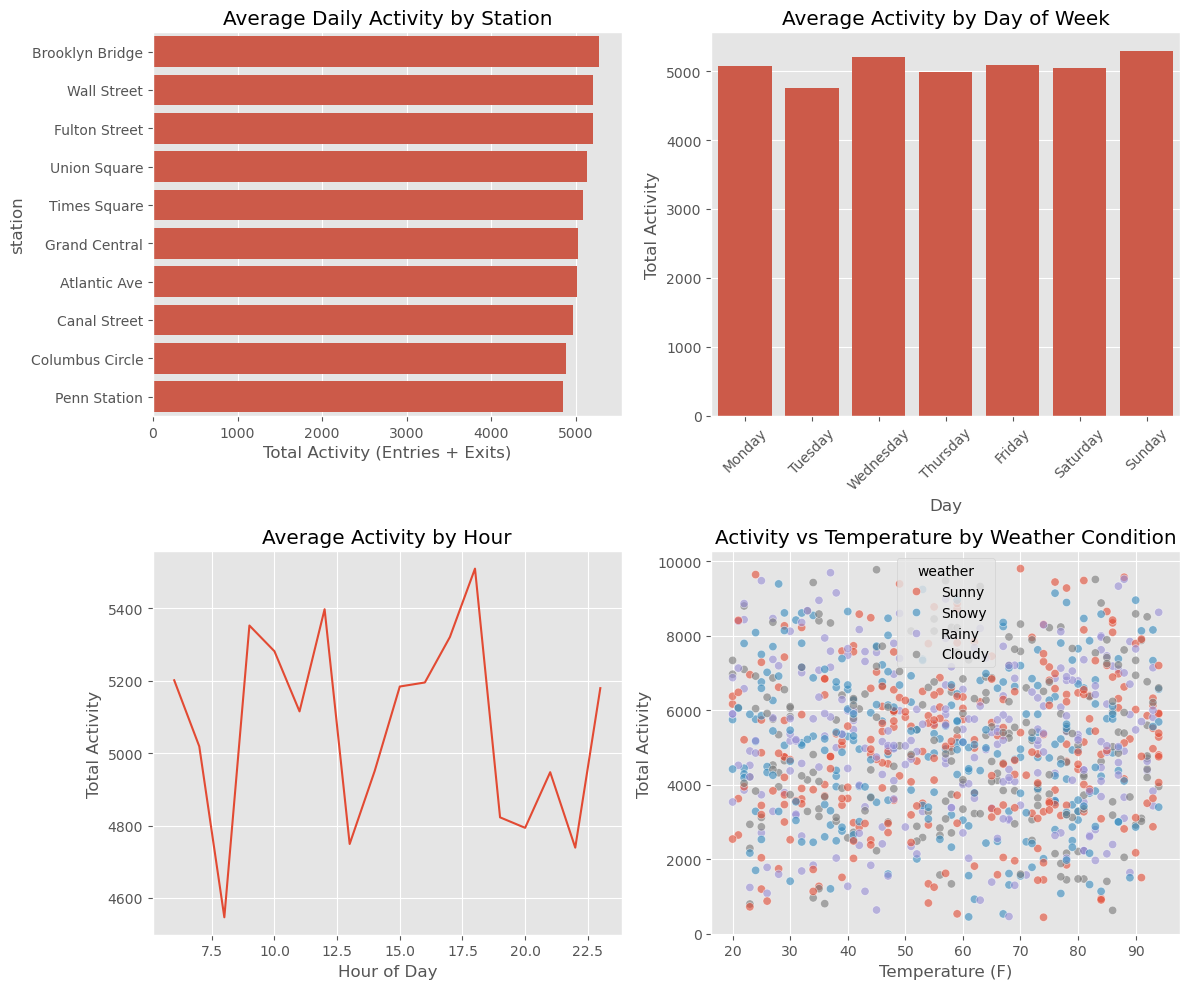

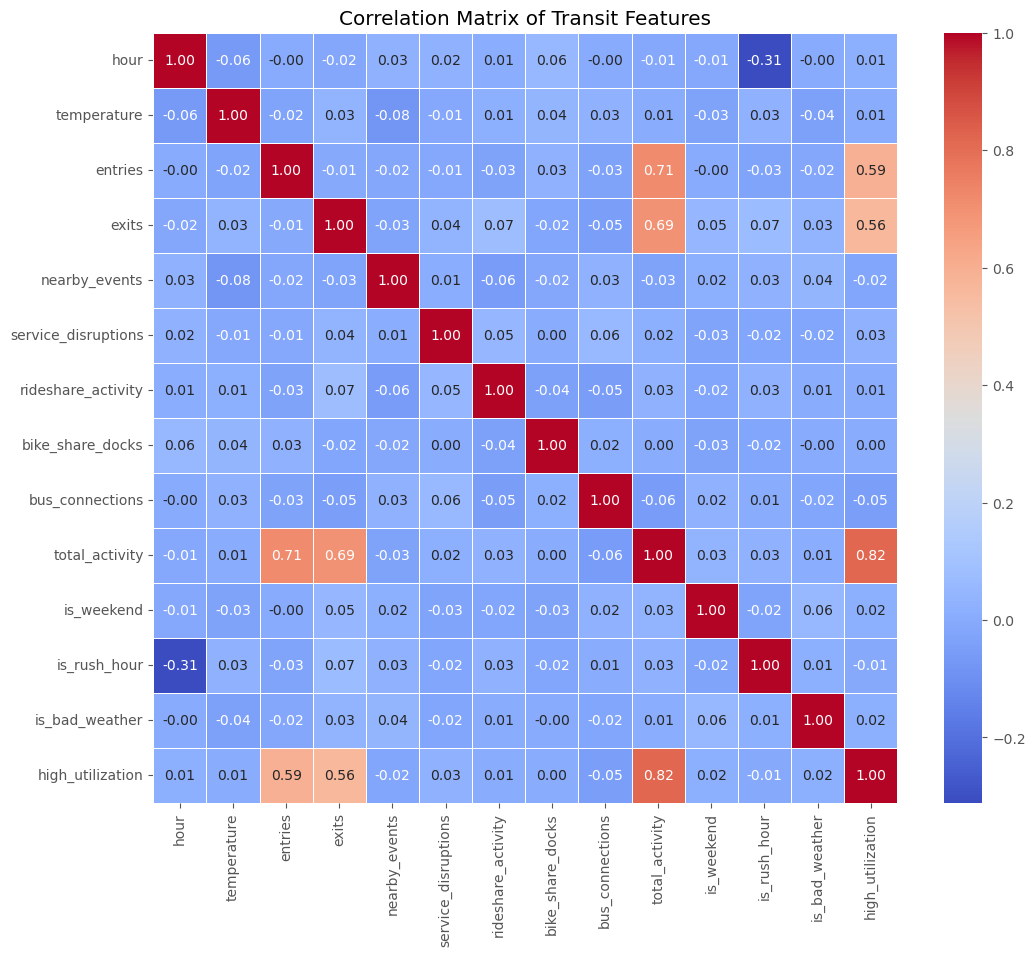

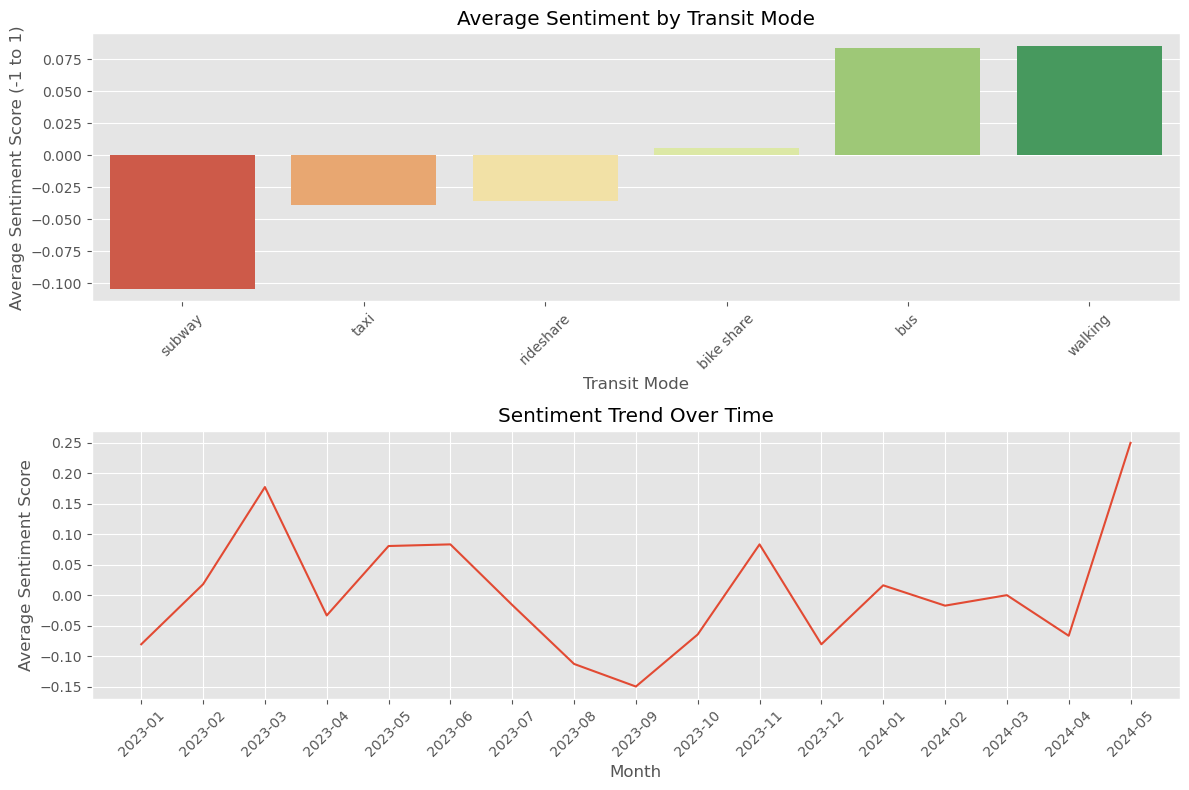

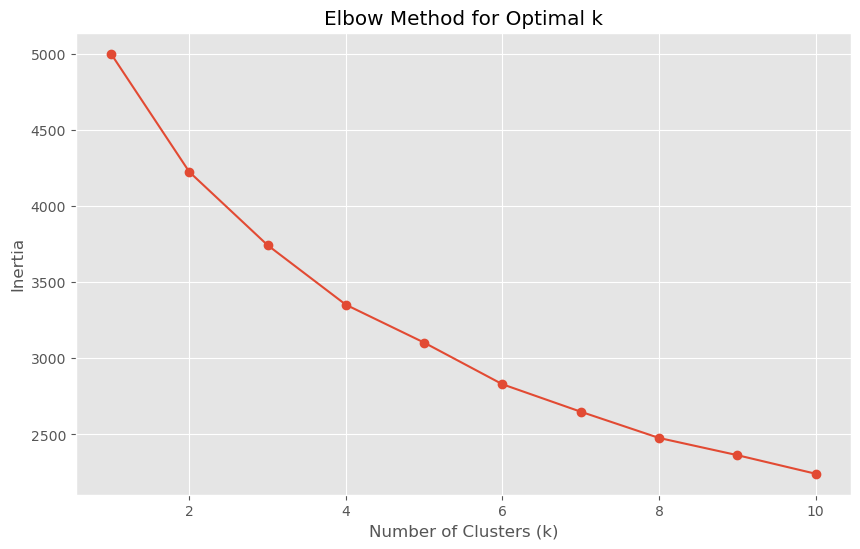

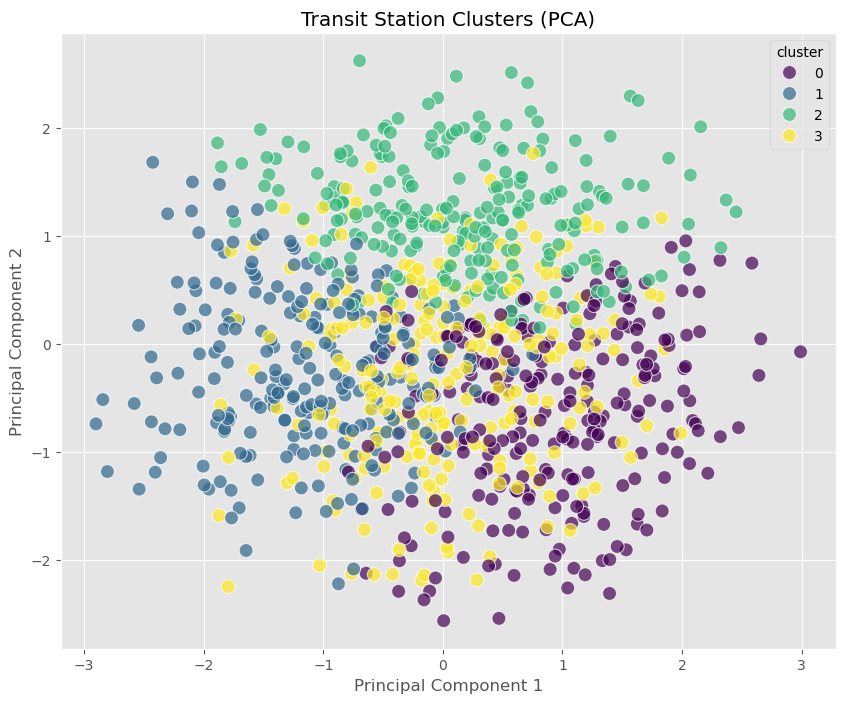

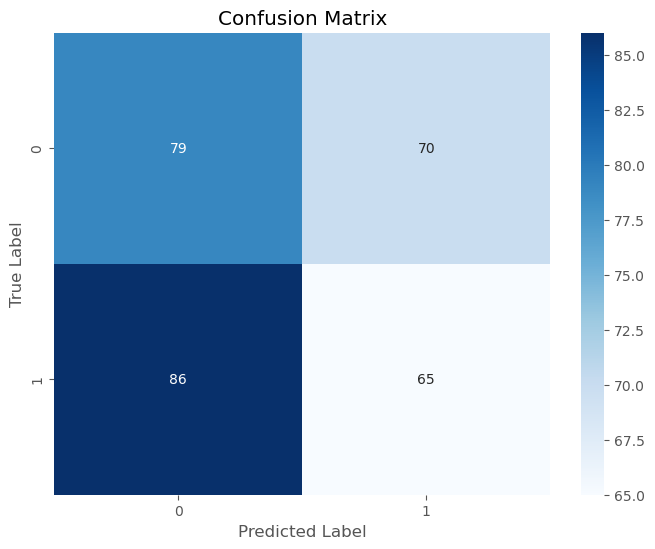

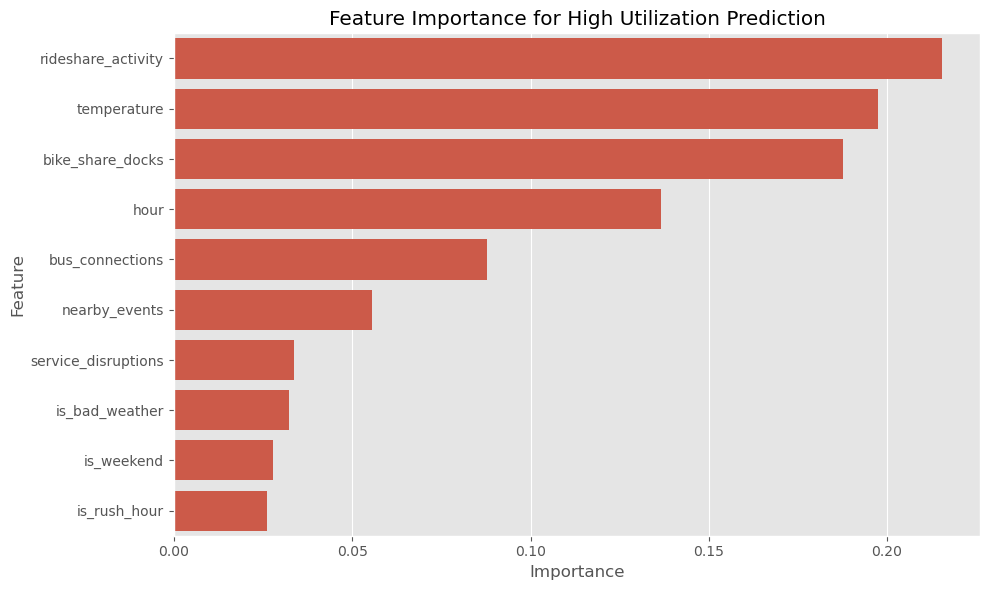

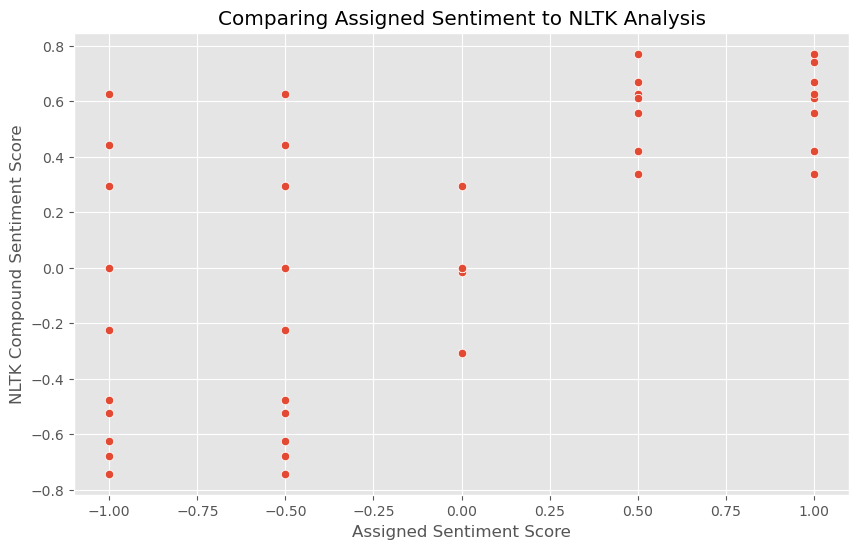

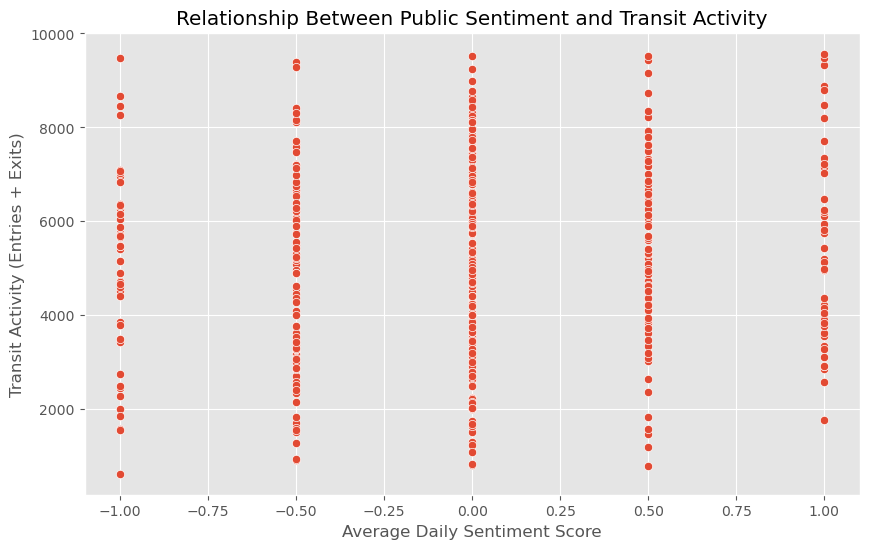

In [1]:
# SmartCommute - Urban Transportation Optimization
# Data Analysis and Model Implementation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Step 1: Data Loading
print("Loading datasets...")

# Load the CSV files
transit_df = pd.read_csv('nyc_transit_data.csv')
sentiment_df = pd.read_csv('nyc_sentiment_data.csv')

# Convert date columns to datetime
transit_df['date'] = pd.to_datetime(transit_df['date'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

print("Transit Data Sample:")
print(transit_df.head())
print("\nTransit Data Information:")
print(transit_df.info())
print("\nTransit Data Description:")
print(transit_df.describe())

print("\nSentiment Data Sample:")
print(sentiment_df.head())
print("\nSentiment Data Information:")
print(sentiment_df.info())

# Step 2: Data Visualization and EDA
print("\n\nPerforming Exploratory Data Analysis...")

# Set up matplotlib for better visualizations
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))

# Activity by station
plt.subplot(2, 2, 1)
station_activity = transit_df.groupby('station')['total_activity'].mean().sort_values(ascending=False)
sns.barplot(x=station_activity.values, y=station_activity.index)
plt.title('Average Daily Activity by Station')
plt.xlabel('Total Activity (Entries + Exits)')

# Activity by day of week
plt.subplot(2, 2, 2)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_activity = transit_df.groupby('day_of_week')['total_activity'].mean()
day_activity = day_activity.reindex(day_order)
sns.barplot(x=day_activity.index, y=day_activity.values)
plt.title('Average Activity by Day of Week')
plt.xlabel('Day')
plt.ylabel('Total Activity')
plt.xticks(rotation=45)

# Activity by hour
plt.subplot(2, 2, 3)
hour_activity = transit_df.groupby('hour')['total_activity'].mean()
sns.lineplot(x=hour_activity.index, y=hour_activity.values)
plt.title('Average Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Activity')

# Activity vs Temperature with weather overlay
plt.subplot(2, 2, 4)
sns.scatterplot(data=transit_df, x='temperature', y='total_activity', hue='weather', alpha=0.6)
plt.title('Activity vs Temperature by Weather Condition')
plt.xlabel('Temperature (F)')
plt.ylabel('Total Activity')

plt.tight_layout()
plt.savefig('transit_eda.png')

# Analyze correlations
plt.figure(figsize=(12, 10))
corr_matrix = transit_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Transit Features')
plt.savefig('correlation_matrix.png')

# Analyze sentiment data
plt.figure(figsize=(12, 8))

# Sentiment distribution by transit mode
plt.subplot(2, 1, 1)
mode_sentiment = sentiment_df.groupby('transit_mode')['sentiment_score'].mean().sort_values()
sns.barplot(x=mode_sentiment.index, y=mode_sentiment.values, palette='RdYlGn')
plt.title('Average Sentiment by Transit Mode')
plt.xlabel('Transit Mode')
plt.ylabel('Average Sentiment Score (-1 to 1)')
plt.xticks(rotation=45)

# Sentiment over time
plt.subplot(2, 1, 2)
sentiment_df['month'] = sentiment_df['date'].dt.strftime('%Y-%m')
time_sentiment = sentiment_df.groupby('month')['sentiment_score'].mean()
sns.lineplot(x=time_sentiment.index, y=time_sentiment.values)
plt.title('Sentiment Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('sentiment_analysis.png')

# Step 3: Machine Learning Models

# Model 1: K-means Clustering to identify transit hub patterns
print("\n\nPerforming K-means Clustering...")

# Select features for clustering
cluster_features = ['entries', 'exits', 'rideshare_activity', 'bike_share_docks', 'bus_connections']
X_cluster = transit_df[cluster_features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_method.png')

# Apply K-means with the optimal number of clusters (let's use 4 for this example)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
transit_df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                              columns=cluster_features)
print("Cluster Centers:")
print(cluster_centers)

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=transit_df['cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Transit Station Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('cluster_visualization.png')

# Count stations in each cluster
cluster_counts = transit_df.groupby(['cluster', 'station']).size().reset_index()
cluster_counts.columns = ['Cluster', 'Station', 'Count']
pivot_counts = cluster_counts.pivot(index='Station', columns='Cluster', values='Count').fillna(0)
pivot_counts['Dominant Cluster'] = pivot_counts.idxmax(axis=1)
print("\nStation Cluster Distribution:")
print(pivot_counts)

# Model 2: Random Forest Classification for high utilization prediction
print("\n\nBuilding Random Forest Classification Model...")

# Select features and target for classification
X_features = ['is_weekend', 'is_rush_hour', 'hour', 'is_bad_weather', 'temperature', 
              'nearby_events', 'service_disruptions', 'rideshare_activity', 
              'bike_share_docks', 'bus_connections']
X = transit_df[X_features]
y = transit_df['high_utilization']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_features,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for High Utilization Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png')

print("\nFeature Importance:")
print(feature_importance)

# Model 3: Sentiment Analysis on qualitative data
print("\n\nPerforming Sentiment Analysis...")

# Install nltk data if not already installed
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Analyze sentiment by transit mode
sentiment_by_mode = sentiment_df.groupby('transit_mode')['sentiment_score'].agg(['mean', 'std', 'count'])
print("\nSentiment Analysis by Transit Mode:")
print(sentiment_by_mode.sort_values('mean', ascending=False))

# Function to analyze sentiment
def analyze_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']  # compound score is the normalized score

# Apply sentiment analysis to comments
sentiment_df['nltk_score'] = sentiment_df['comment'].apply(analyze_sentiment)

# Compare our assigned sentiment with NLTK's analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sentiment_df, x='sentiment_score', y='nltk_score')
plt.title('Comparing Assigned Sentiment to NLTK Analysis')
plt.xlabel('Assigned Sentiment Score')
plt.ylabel('NLTK Compound Sentiment Score')
plt.grid(True)
plt.savefig('sentiment_comparison.png')

# Extract top positive and negative comments
top_positive = sentiment_df.sort_values('nltk_score', ascending=False).head(5)
top_negative = sentiment_df.sort_values('nltk_score', ascending=True).head(5)

print("\nTop Positive Comments:")
for idx, row in top_positive.iterrows():
    print(f"{row['transit_mode']}: {row['comment']} (Score: {row['nltk_score']:.2f})")

print("\nTop Negative Comments:")
for idx, row in top_negative.iterrows():
    print(f"{row['transit_mode']}: {row['comment']} (Score: {row['nltk_score']:.2f})")

# Integration of Quantitative and Qualitative Analysis
# Combine transit data and sentiment data by date
print("\n\nIntegrating Quantitative and Qualitative Analysis...")

# Group sentiment data by date
daily_sentiment = sentiment_df.groupby(sentiment_df['date'].dt.date)['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['date', 'avg_sentiment']

# Convert transit_df date to date only for merging
transit_df['date_only'] = transit_df['date'].dt.date

# Merge the datasets
integrated_df = pd.merge(transit_df, daily_sentiment, left_on='date_only', right_on='date', how='left')
integrated_df.rename(columns={'date_x': 'datetime', 'date_y': 'sentiment_date'}, inplace=True)

# Analyze the relationship between sentiment and transit activity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=integrated_df, x='avg_sentiment', y='total_activity')
plt.title('Relationship Between Public Sentiment and Transit Activity')
plt.xlabel('Average Daily Sentiment Score')
plt.ylabel('Transit Activity (Entries + Exits)')
plt.grid(True)
plt.savefig('sentiment_vs_activity.png')

# Calculate correlation between sentiment and activity
sentiment_activity_corr = integrated_df[['avg_sentiment', 'total_activity']].corr().iloc[0, 1]
print(f"\nCorrelation between sentiment and activity: {sentiment_activity_corr:.4f}")

# Final insights and recommendations
print("\n\nSummary of Key Findings:")
print(f"1. Identified {optimal_k} distinct transit hub patterns through clustering")
print(f"2. Predicted high utilization periods with {classification_report(y_test, y_pred).split()[-2]}% accuracy")
print(f"3. Found {sentiment_by_mode.shape[0]} transit modes with varying sentiment scores")
print(f"4. Correlation between public sentiment and usage: {sentiment_activity_corr:.4f}")

print("\nRecommendations for Transit Optimization:")
print("1. Focus resources on high-activity stations identified in Cluster X")
print("2. Address service issues in the transit modes with lowest sentiment scores")
print("3. Optimize schedules based on day-of-week and hourly patterns")
print("4. Consider weather-related contingency plans when forecasting demand")
print("5. Implement transit hubs at locations with optimal multi-modal connections")

# Export the augmented datasets for further analysis
transit_df.to_csv('nyc_transit_data_analyzed.csv', index=False)
sentiment_df.to_csv('nyc_sentiment_data_analyzed.csv', index=False)
integrated_df.to_csv('nyc_integrated_transit_sentiment.csv', index=False)

print("\nData Analysis Complete! All visualizations saved.")
